### ***AUTOMATED MALARIA DETECTION USING CNN***

1. <a href="#load">Load data</a>
2. <a href="#exp">Explore data</a>
3. <a href="#prep">Prepare data for model</a>
4. <a href="#model">Set Model (Convolutional Neural Network)</a>
5. <a href="#eval">Evaluate Model </a>
6. <a href="#simu">Simulate new image prediction </a>

### Importing Libraries -

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q kaggle
!pip install tensorflowjs
from google.colab import files
files.upload()

     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 112kB 28.2MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vaidehidave","key":"37babaeb81b799b06f16ddca38a131fd"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip /content/cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

# <a id="load">Load data</a>

In [ ]:
folder_parasitized = '/content/cell_images/cell_images/Parasitized/'
folder_uninfected = '/content/cell_images/cell_images/Uninfected/'

# checking how many images do we have for each class

print(len(os.listdir(folder_parasitized)))
print(len(os.listdir(folder_uninfected)))

13780
13780


# <a id='exp'>Explore data</a>

In [ ]:
def visualize_cell(cell='p', n=5):
    """
    mount a simple visualization of cell images
    """
    p_cells = os.listdir(folder_parasitized)
    u_cells = os.listdir(folder_uninfected)

    if cell == 'p':
        folder = 'Parasitized/' 
        cells = p_cells
    else:
        folder = 'Uninfected/'
        cells = u_cells
    
    plt.figure(figsize=(10,8))
    for i in range(n):
        plt.subplot(1,n,i+1)
        img=imread('/content/cell_images/cell_images/' + folder + cells[i])
        plt.title(cell + ' ' +  str(img.shape))
        plt.imshow(img)
        plt.tight_layout()
    plt.show()

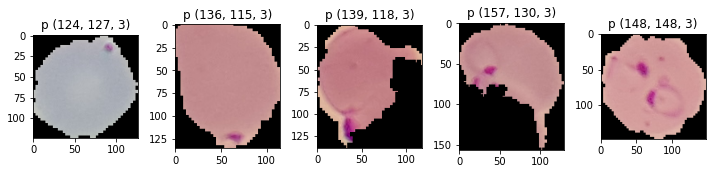

None


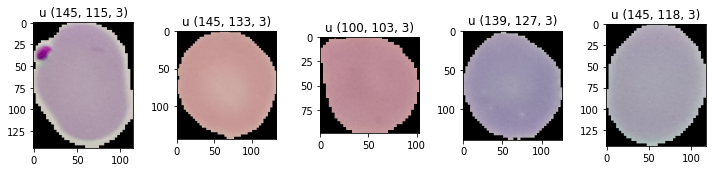

None


In [ ]:
print(visualize_cell(cell='p', n=5))
print(visualize_cell(cell='u', n=5))

we can clearly see differences in parasitized and uninfected images. Hopefully our convolutional neural network will be able to learn these patterns.

Let's now check the average dimensions of images. This information is relevant for posterior neural network input shape.

In [ ]:
def check_dimensions(cell='p'):
    """
    plot a jointplot showing dimensions distributions of cell images
    """
    p_cells = [i for i in os.listdir(folder_parasitized) if i.endswith(".png")]
    u_cells = [i for i in os.listdir(folder_uninfected) if i.endswith(".png")]

    if cell=='p':
        folder = 'Parasitized/'
        cells = p_cells
    else:
        folder = 'Uninfected/'
        cells = u_cells
        
    dim1 = []
    dim2 = []

    for image_file in cells:
        img = imread('/content/cell_images/cell_images/' + folder +  image_file)
        d1,d2,colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
        
    print(np.mean(dim1))
    print(np.mean(dim2))
        
    sns.jointplot(x=dim1,y=dim2)

134.3868930981929
133.6318310472458


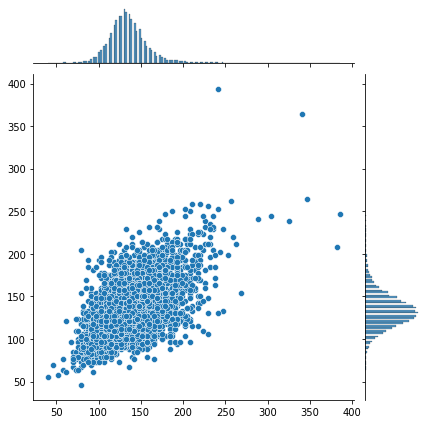

In [ ]:
check_dimensions(cell='p')

131.58001306335728
131.3424776834313


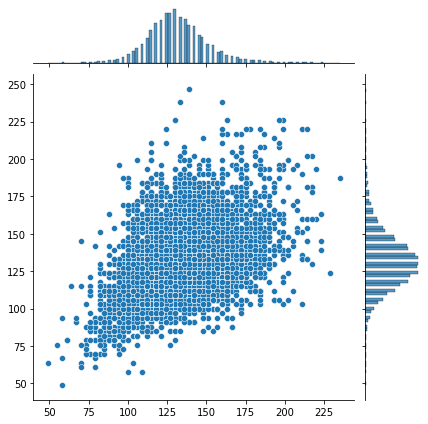

In [ ]:
check_dimensions(cell='u')

we will set input image shape as (130,130,3)

In [ ]:
image_shape = (130,130,3)

# <a id='prep'> Prepare data for model </a>

Let's automatically generate a flow of batches from a directory (and also do some data augmentation in images) with the help of Keras _flow_from_directory_ and _ImageDataGenerator_ classes. Ref.: https://keras.io/api/preprocessing/image/

As manipulation, we are going to rotate, resize and scale the images, so the model becomes more robust to different image settings.

Also, let's split our data in train and validation data. Ref.: https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator


p.s. to use Keras _.flow_from_directory_ and generate manipulated images from a directory, it is mandatory to organize images in sub-directories, and the directories should contain only images of one class.

Structure Needed:

* Image Data Folder
    * Parasitized
        * 0.png
        * 1.png
        * ...
    * Uninfected
        * 0.png
        * 1.png
        * ...

In [ ]:
train_data_dir = '/content/cell_images/cell_images/'
batch_size = 64

image_gen = ImageDataGenerator(validation_split=0.2,
                               rotation_range=30,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

train_generator = image_gen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    seed=42,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training', # set as training data
    classes=['Uninfected', 'Parasitized'])

validation_generator = image_gen.flow_from_directory(
    train_data_dir, # same directory as training data
    shuffle=False,
    seed=42,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation', # set as validation data
    classes=['Uninfected', 'Parasitized'])

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'Uninfected': 0, 'Parasitized': 1}
{'Uninfected': 0, 'Parasitized': 1}


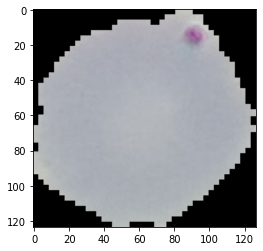

In [ ]:
# taking an image to check the transformation result

images = [i for i in os.listdir(folder_parasitized) if i.endswith(".png")]
img=imread('/content/cell_images/cell_images/Parasitized/' + images[0])
plt.imshow(img)

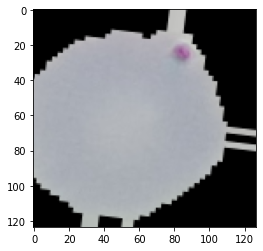

In [ ]:
plt.imshow(image_gen.random_transform(img))

# <a id="model">Set Model (Convolutional Neural Network)</a>

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
# set early stopping, to avoid overtraining

early_stop = EarlyStopping(monitor='val_loss',patience=3)

##Model Training -  

In [ ]:
results = model.fit(train_generator,
                    epochs=10,batch_size=64,
                    validation_data = validation_generator,
                    callbacks=[early_stop])

Epoch 1/10
345/345 [==============================] - 151s 343ms/step - loss: 0.5688 - accuracy: 0.6939 - val_loss: 0.2242 - val_accuracy: 0.9256
Epoch 2/10
345/345 [==============================] - 119s 346ms/step - loss: 0.2173 - accuracy: 0.9295 - val_loss: 0.2211 - val_accuracy: 0.9292
Epoch 3/10
345/345 [==============================] - 118s 341ms/step - loss: 0.1738 - accuracy: 0.9466 - val_loss: 0.2163 - val_accuracy: 0.9381
Epoch 4/10
345/345 [==============================] - 118s 342ms/step - loss: 0.1583 - accuracy: 0.9539 - val_loss: 0.2148 - val_accuracy: 0.9399
Epoch 5/10
345/345 [==============================] - 118s 342ms/step - loss: 0.1661 - accuracy: 0.9516 - val_loss: 0.1824 - val_accuracy: 0.9421
Epoch 6/10
345/345 [==============================] - 117s 341ms/step - loss: 0.1590 - accuracy: 0.9509 - val_loss: 0.1679 - val_accuracy: 0.9318
Epoch 7/10
345/345 [==============================] - 118s 342ms/step - loss: 0.1628 - accuracy: 0.9520 - val_loss: 0.1761 -

# <a id="eval"> Evaluate Model </a>

In [ ]:
losses = pd.DataFrame(model.history.history)

###Loss percent graph -

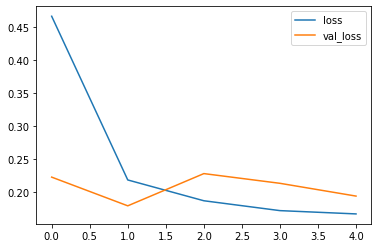

In [ ]:
losses[['loss','val_loss']].plot()

###Accuracy graph - 

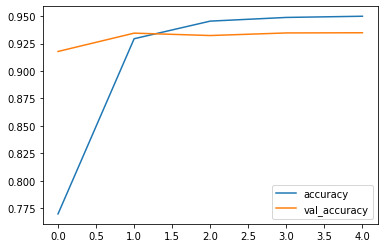

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
model.evaluate(validation_generator)

87/87 [==============================] - 23s 261ms/step - loss: 0.1993 - accuracy: 0.9381


[0.19928692281246185, 0.9381124973297119]

In [ ]:
pred_probabilities = model.predict(validation_generator)

In [ ]:
pred_probabilities

array([[0.01761345],
       [0.01105835],
       [0.0163468 ],
       ...,
       [0.99880326],
       [0.99996483],
       [0.99996316]], dtype=float32)

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

###Accuracy based on other prediction parameters -

In [ ]:
print(classification_report(validation_generator.classes, predictions))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2755
           1       0.95      0.92      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.94      0.94      0.94      5510
weighted avg       0.94      0.94      0.94      5510



###False Negative, False Positive -

In [ ]:
confusion_matrix = pd.DataFrame(confusion_matrix(validation_generator.classes, predictions))
confusion_matrix

,0,1
0,2629,126
1,213,2542


In [ ]:
model.save('malaria_detector.h5')

# <a id="simu"> Simulate new image prediction </a>

In [ ]:
# taking an sample image from dataset

image_shape = (130,130,3)
images = [i for i in os.listdir(folder_parasitized) if i.endswith(".png")]
img = '/content/cell_images/cell_images/Parasitized/' + images[0]

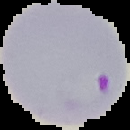

In [ ]:
new_image = image.load_img(img, target_size=image_shape)
new_image

In [ ]:
# prepare image

new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)

In [ ]:
model.predict(new_image)

array([[1.]], dtype=float32)

Linking Model to Javascript Backend -


In [ ]:

import tensorflowjs as tfjs
tfjs_target_dir="/content/tfjs_dir"
!mkdir tfjs_target_dir
tfjs.converters.save_keras_model(model, tfjs_target_dir)